#Further Topics in using Unet for Segmentation


In the previous notebook we scaled images down from 512x512 to 128x128 in order that memory would not be overloaded. Here we examine **tiling** to cut the images into smaller pieces to classify.

We also cover different **loss functions** and **optimisers**.

#Setup

**Connecting to a GPU**

In the *Runtime* menu, select *Change runtime type*. 
Then select *GPU* as the hardware type.


Then check that a GPU is available and what version of Tensorflow is running via the following code:

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
    
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Tensorflow version: ",tf.__version__)

1 Physical GPUs, 1 Logical GPUs
Num GPUs Available:  1
Tensorflow version:  2.4.1


Load some useful libraries and make sure we've got keras-unet installed

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import sys
from PIL import Image

!pip install keras-unet


from numpy.random import seed # make everything reproducible
seed(1)

## Load data

Connect to your Google Drive

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


Find and load the training images

In [4]:
img_files = glob.glob("/content/gdrive/My Drive/Colab Notebooks/intro-to-ml-for-imaging-master/data/isbi2015/train/image/*.png")
mask_files = glob.glob("/content/gdrive/My Drive/Colab Notebooks/intro-to-ml-for-imaging-master/data/isbi2015/train/label/*.png")

print("Found files:")
print("Images: ", img_files)
print("Masks: ",mask_files)


imgs_list = []
masks_list = []
for image, mask in zip(img_files, mask_files):
    
    imgs_list.append(np.array(Image.open(image).resize((512,512))))
    
    im = Image.open(mask).resize((512,512))
    masks_list.append(np.array(im))

Found files:
Images:  ['/content/gdrive/My Drive/Colab Notebooks/intro-to-ml-for-imaging-master/data/isbi2015/train/image/0.png', '/content/gdrive/My Drive/Colab Notebooks/intro-to-ml-for-imaging-master/data/isbi2015/train/image/1.png', '/content/gdrive/My Drive/Colab Notebooks/intro-to-ml-for-imaging-master/data/isbi2015/train/image/10.png', '/content/gdrive/My Drive/Colab Notebooks/intro-to-ml-for-imaging-master/data/isbi2015/train/image/11.png', '/content/gdrive/My Drive/Colab Notebooks/intro-to-ml-for-imaging-master/data/isbi2015/train/image/12.png', '/content/gdrive/My Drive/Colab Notebooks/intro-to-ml-for-imaging-master/data/isbi2015/train/image/13.png', '/content/gdrive/My Drive/Colab Notebooks/intro-to-ml-for-imaging-master/data/isbi2015/train/image/14.png', '/content/gdrive/My Drive/Colab Notebooks/intro-to-ml-for-imaging-master/data/isbi2015/train/image/15.png', '/content/gdrive/My Drive/Colab Notebooks/intro-to-ml-for-imaging-master/data/isbi2015/train/image/16.png', '/conte

Convert image list into numpy array, reshape the image arrays into the form needed by Unet, and normalise image intensities to range 0..1 

In [5]:
imgs_np = np.asarray(imgs_list)
masks_np = np.asarray(masks_list)

imgs_np = imgs_np.reshape(imgs_np.shape[0], imgs_np.shape[1], imgs_np.shape[2], 1)
masks_np = masks_np.reshape(masks_np.shape[0], masks_np.shape[1], masks_np.shape[2], 1)

x = np.asarray(imgs_np, dtype=np.float32)/255
y = np.asarray(masks_np, dtype=np.float32)/255

print("Image and mask data shapes: ",imgs_np.shape, masks_np.shape)



Image and mask data shapes:  (30, 512, 512, 1) (30, 512, 512, 1)


## Split the sets into training, validation and test sets

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_testval, y_train, y_testval = train_test_split(x, y, test_size=0.5, random_state=0)

x_test, x_val, y_test, y_val = train_test_split(x_testval, y_testval, test_size=0.5, random_state=0)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

x_train:  (15, 512, 512, 1)
y_train:  (15, 512, 512, 1)
x_val:  (8, 512, 512, 1)
y_val:  (8, 512, 512, 1)
x_test:  (7, 512, 512, 1)
y_test:  (7, 512, 512, 1)


##  Tile the 512x512 images into 128x128 tiles

The *get_patches* function is provided by keras-unet. It chops up each image into square tiles of size *size*. By setting the *stride* here to 128 we are creating a set of non-overlapping tiles. 

Essentially each 512x512 tile becomes four 128x128 tiles.

We do this for both the original images and the segmented (mask) images.



In [7]:
from keras_unet.utils import get_patches

x_train_tiles = get_patches(
    img_arr=x_train, 
    size=128, 
    stride=128)
x_val_tiles = get_patches(
    img_arr=x_val, 
    size=128, 
    stride=128)
x_test_tiles = get_patches(
    img_arr=x_test, 
    size=128, 
    stride=128)

y_train_tiles = get_patches(
    img_arr=y_train, 
    size=128, 
    stride=128)
y_val_tiles = get_patches(
    img_arr=y_val, 
    size=128, 
    stride=128)
y_test_tiles = get_patches(
    img_arr=y_test, 
    size=128, 
    stride=128)

print("x_train_tiles: ", x_train_tiles.shape)
print("y_train_tiles: ", y_train_tiles.shape)
print("x_val_tiles_tiles: ", x_val_tiles.shape)
print("y_val_tiles: ", y_val_tiles.shape)
print("x_test_tiles: ", x_test_tiles.shape)
print("y_test_tiles: ", y_test_tiles.shape)


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------
x_train_tiles:  (240, 128, 128, 1)
y_train_tiles:  (240, 128, 128, 1)
x_val_tiles_tiles:  (128, 128, 128, 1)
y_val_tiles:  (128, 128, 128, 1)
x_test_tiles:  (112, 128, 128, 1)
y_test_tiles:  (112, 128, 128, 1)


Lets look at some of the tiles

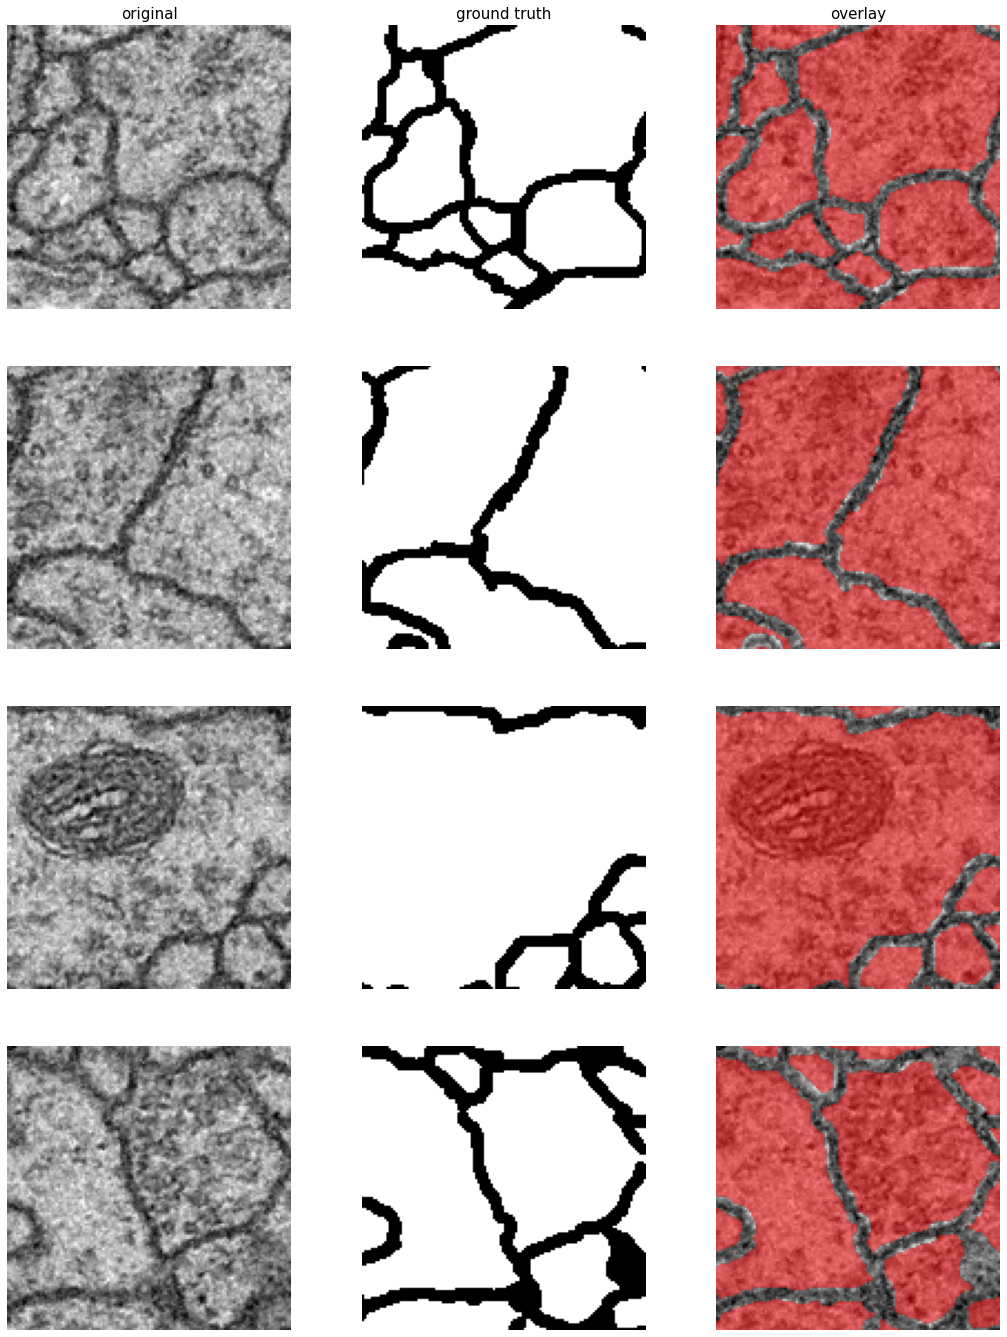

In [8]:

from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=x_train_tiles, mask_imgs=y_train_tiles, nm_img_to_plot=4, figsize=6)
   

## Prepare train generator with data augmentation

In [9]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    x_train_tiles, y_train_tiles, batch_size=10, # reducing batch_size can help if you run out of memory
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=20,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

Have a look at some of the augmented data

(10, 128, 128, 1) (10, 128, 128, 1)


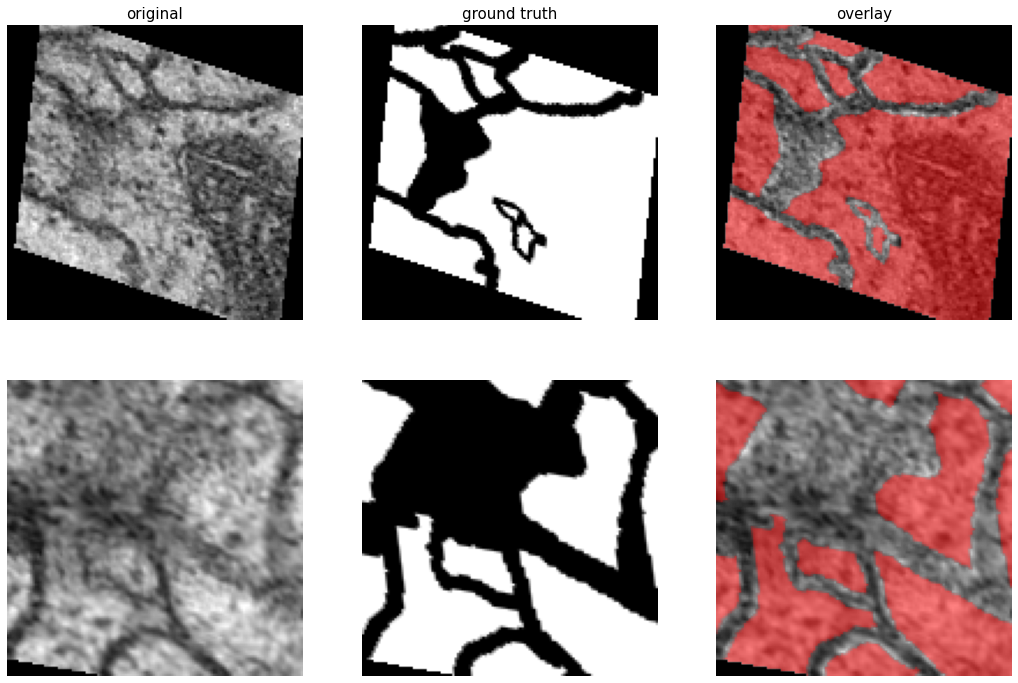

In [10]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

#Create and initialize network

Create a custom keras-unet with parameters as before

In [11]:
from keras_unet.models import custom_unet

input_shape = x_train_tiles[0].shape

model = custom_unet(
    input_shape=input_shape,
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)

This time we will do some checkpointing to regularly save the model during training. Always good to do if you are doing long training runs. We wont really need it here as the problem is still quite small, but it is a useful trick to know.

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint
model_filename = 'unet_custom_membrane-tiles.h5'

callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)

# tf.keras.utils.plot_model(model, show_shapes=True)

#Compile the model and train it

This time we will use the **Jaccard distance** (intersection over union) as the loss function. We also record the **intersection over union (iou)** as a metric for later plotting.

In [13]:
from tensorflow.keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

model.compile(
    optimizer=Adam(), 
    #optimizer=SGD(lr=0.01, momentum=0.99),
    #loss='binary_crossentropy',
    loss=jaccard_distance,
    metrics=[iou, iou_thresholded]
)

In [14]:
history = model.fit(
    train_gen,
    steps_per_epoch=100,
    epochs=12,  
    validation_data=(x_val_tiles, y_val_tiles),
    callbacks=[callback_checkpoint]
)

Epoch 1/20
100/100 [==============================] - 60s 218ms/step - loss: 0.2528 - iou: 0.7139 - iou_thresholded: 0.7284 - val_loss: 0.1854 - val_iou: 0.7975 - val_iou_thresholded: 0.7980

Epoch 00001: val_loss improved from inf to 0.18536, saving model to unet_custom_membrane-tiles.h5
Epoch 2/20
100/100 [==============================] - 16s 157ms/step - loss: 0.1654 - iou: 0.7943 - iou_thresholded: 0.7948 - val_loss: 0.1735 - val_iou: 0.8053 - val_iou_thresholded: 0.8057

Epoch 00002: val_loss improved from 0.18536 to 0.17352, saving model to unet_custom_membrane-tiles.h5
Epoch 3/20
100/100 [==============================] - 16s 158ms/step - loss: 0.1556 - iou: 0.8015 - iou_thresholded: 0.8019 - val_loss: 0.1571 - val_iou: 0.8153 - val_iou_thresholded: 0.8157

Epoch 00003: val_loss improved from 0.17352 to 0.15713, saving model to unet_custom_membrane-tiles.h5
Epoch 4/20
100/100 [==============================] - 16s 156ms/step - loss: 0.1351 - iou: 0.8261 - iou_thresholded: 0.826

There is a handy history plotting function in keras-unet which we can use here

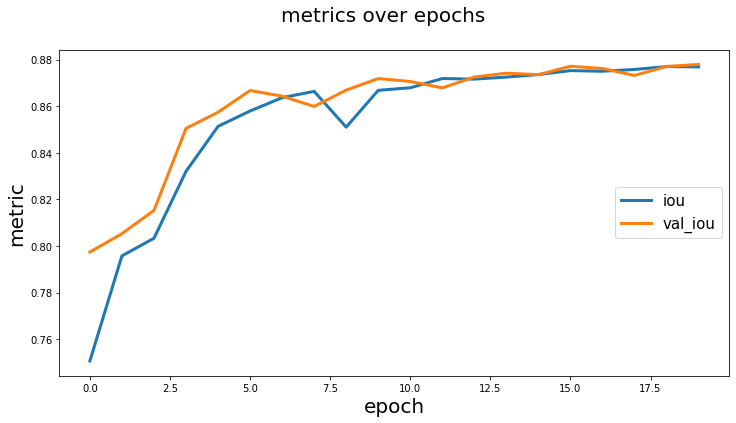

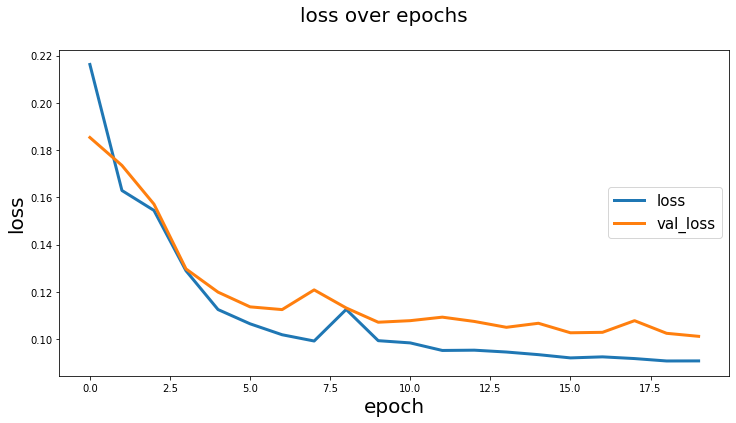

In [15]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

#Predict on the tiles of the test set

Create predictions on *tiles* of the test set

In [16]:
model.load_weights(model_filename)

y_test_pred_tiles = model.predict(x_test_tiles)


Show some of the predictions along with the targets

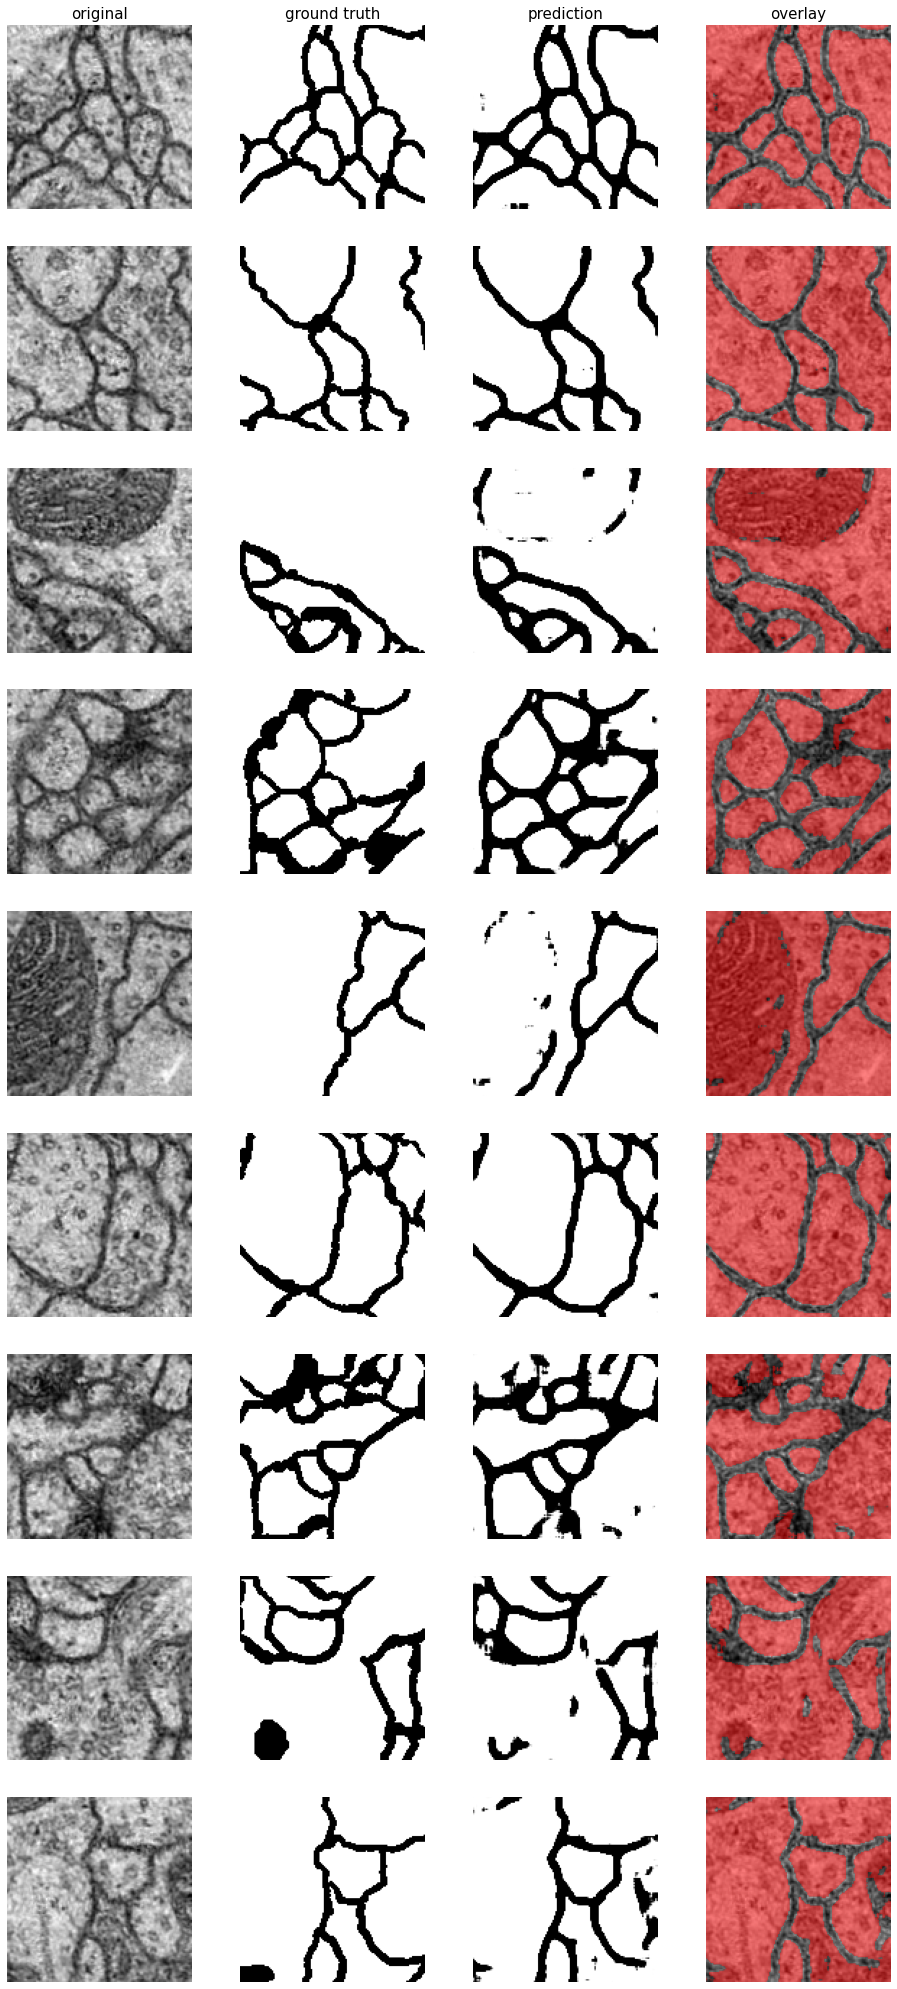

In [17]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=x_test_tiles, mask_imgs=y_test_tiles, pred_imgs=y_test_pred_tiles, nm_img_to_plot=9)

#Show the test set tile predictions together again

Recombine tiles into complete images

In [18]:
from keras_unet.utils import reconstruct_from_patches

#(img_arr, org_img_size, stride=None, size=None):
y_test_preds = reconstruct_from_patches(img_arr=y_test_pred_tiles[:,:,:], org_img_size=(512,512))

print("Output shape: ",y_test_preds.shape)


Output shape:  (7, 512, 512, 1)


Lets have a look at the recombined predictions on a complete image

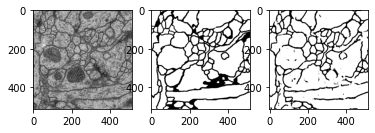

In [19]:
img_num = 1

img = x_test[img_num,:,:,-1]
mask = y_test[img_num,:,:,-1]
mask_pred = y_test_preds[img_num,:,:,-1]

f, axarr = plt.subplots(1,3)
axarr[0].imshow(img, cmap='gray')
axarr[1].imshow(mask, cmap='gray')
axarr[2].imshow(mask_pred, cmap='gray')

Or we could use the keras-unet **plot_images** function to show them all

In [20]:
plot_imgs(org_imgs=x_test, mask_imgs=y_test, pred_imgs=y_test_preds, nm_img_to_plot=7)

Output hidden; open in https://colab.research.google.com to view.

#Using SGD instead of Adam as the optimiser

SGD (Stochastic Gradient Descent) :  parameter update for each training example.

Adam (Adaptive Moment Estimation): adaptive learning rates for each parameter.

Epoch 1/20
100/100 [==============================] - 18s 169ms/step - loss: 0.2818 - iou: 0.6992 - iou_thresholded: 0.7034 - val_loss: 0.1983 - val_iou: 0.7949 - val_iou_thresholded: 0.7948
Epoch 2/20
100/100 [==============================] - 16s 162ms/step - loss: 0.2045 - iou: 0.7637 - iou_thresholded: 0.7643 - val_loss: 0.1629 - val_iou: 0.8102 - val_iou_thresholded: 0.8103
Epoch 3/20
100/100 [==============================] - 16s 158ms/step - loss: 0.1538 - iou: 0.8038 - iou_thresholded: 0.8038 - val_loss: 0.1591 - val_iou: 0.8163 - val_iou_thresholded: 0.8163
Epoch 4/20
100/100 [==============================] - 16s 156ms/step - loss: 0.1426 - iou: 0.8143 - iou_thresholded: 0.8143 - val_loss: 0.1601 - val_iou: 0.8230 - val_iou_thresholded: 0.8230
Epoch 5/20
100/100 [==============================] - 16s 157ms/step - loss: 0.1384 - iou: 0.8215 - iou_thresholded: 0.8215 - val_loss: 0.1451 - val_iou: 0.8339 - val_iou_thresholded: 0.8339
Epoch 6/20
100/100 [=========================

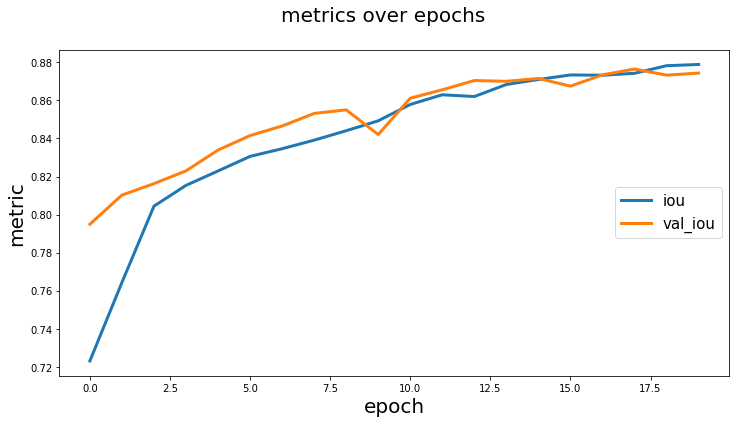

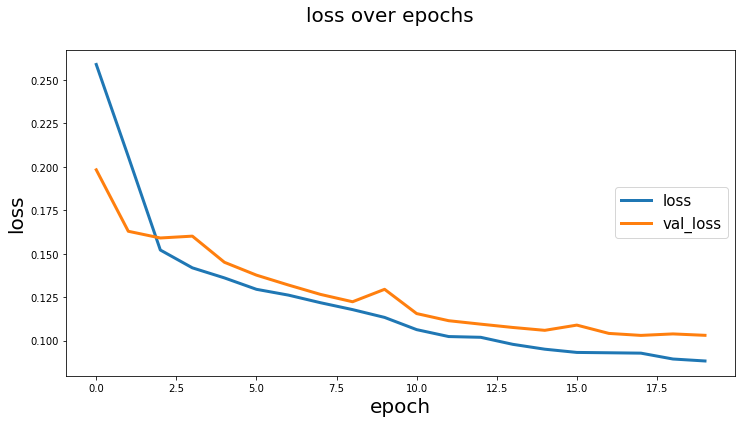

In [21]:

# How does the learning compare?

model_SGD = custom_unet(
    input_shape=input_shape,
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)

model_SGD.compile(
    #optimizer=Adam(), 
    optimizer=SGD(lr=0.01, momentum=0.99),
    #loss='binary_crossentropy',
    loss=jaccard_distance,
    metrics=[iou, iou_thresholded]
)

history_SGD = model_SGD.fit(
    train_gen,
    steps_per_epoch=100,
    epochs=12,  
    validation_data=(x_val_tiles, y_val_tiles),
    #callbacks=[callback_checkpoint]
)

plot_segm_history(history_SGD)

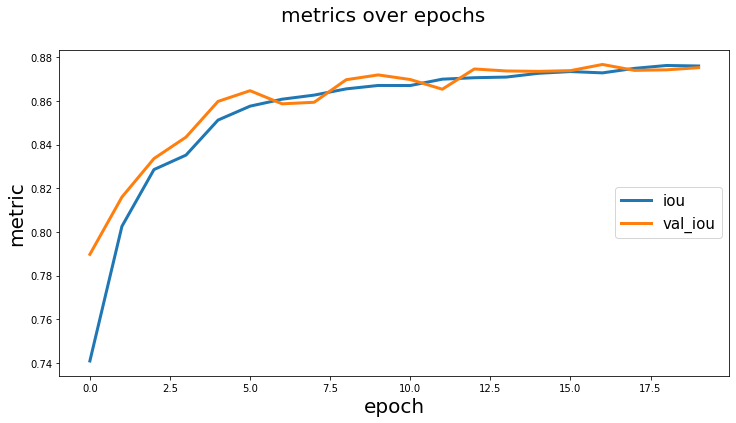

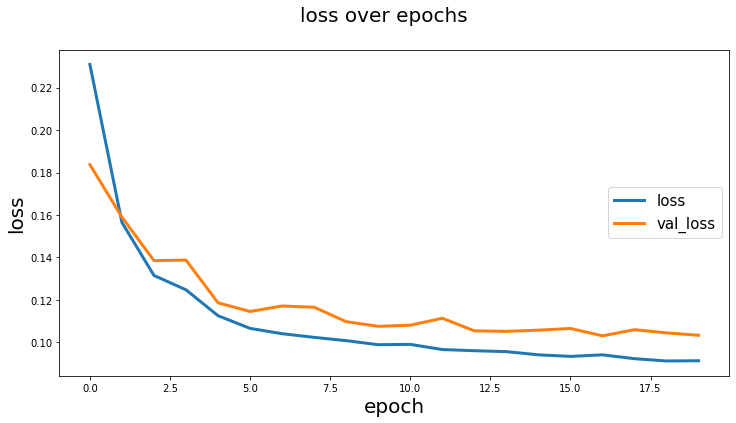

In [ ]:
# The Adam learning curve that we ran before ...
plot_segm_history(history)

#Binary cross entropy as loss function instead of Jaccard

> Indented block



Epoch 1/12
100/100 [==============================] - 18s 163ms/step - loss: 0.6484 - accuracy: 0.7261 - val_loss: 0.3764 - val_accuracy: 0.8269
Epoch 2/12
100/100 [==============================] - 16s 161ms/step - loss: 0.3233 - accuracy: 0.8087 - val_loss: 0.3235 - val_accuracy: 0.8510
Epoch 3/12
100/100 [==============================] - 16s 157ms/step - loss: 0.2868 - accuracy: 0.8289 - val_loss: 0.2900 - val_accuracy: 0.8741
Epoch 4/12
100/100 [==============================] - 16s 155ms/step - loss: 0.2614 - accuracy: 0.8444 - val_loss: 0.2528 - val_accuracy: 0.8919
Epoch 5/12
100/100 [==============================] - 16s 156ms/step - loss: 0.2351 - accuracy: 0.8587 - val_loss: 0.2568 - val_accuracy: 0.8920
Epoch 6/12
100/100 [==============================] - 16s 157ms/step - loss: 0.2250 - accuracy: 0.8625 - val_loss: 0.2328 - val_accuracy: 0.9023
Epoch 7/12
100/100 [==============================] - 16s 158ms/step - loss: 0.2146 - accuracy: 0.8675 - val_loss: 0.2550 - val_ac

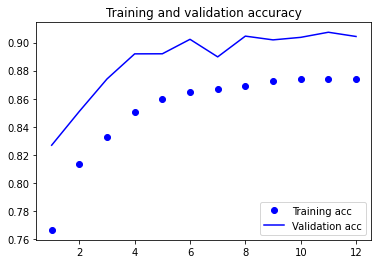

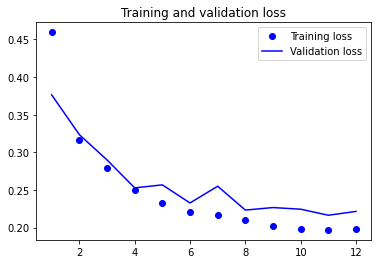

In [23]:
# how to the predictions look in comparison to jaccard/iou?

model_binx = custom_unet(
    input_shape=input_shape,
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)

model_binx.compile(
    optimizer=Adam(), 
    #optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    #metrics=[iou, iou_thresholded]
    metrics=['accuracy']
)

history_binx = model_binx.fit(
    train_gen,
    steps_per_epoch=100,
    epochs=12,  
    validation_data=(x_val_tiles, y_val_tiles),
    #callbacks=[callback_checkpoint]
)

acc = history_binx.history['accuracy']
val_acc = history_binx.history['val_accuracy']
loss = history_binx.history['loss']
val_loss = history_binx.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##How do the results compare?

In [24]:
y_test_pred_binx_tiles = model_binx.predict(x_test_tiles)

The predicted masks using Jaccard as before

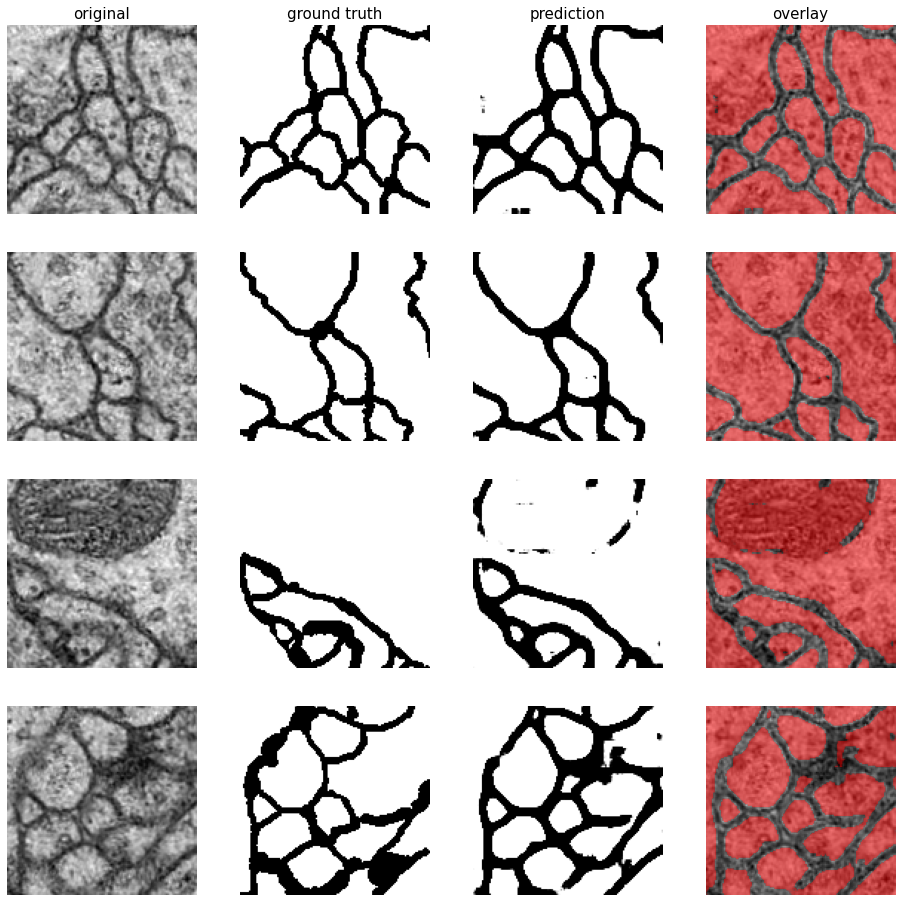

In [25]:
plot_imgs(org_imgs=x_test_tiles, mask_imgs=y_test_tiles, pred_imgs=y_test_pred_tiles, nm_img_to_plot=4)

Prediction maskes using binary cross entropy training

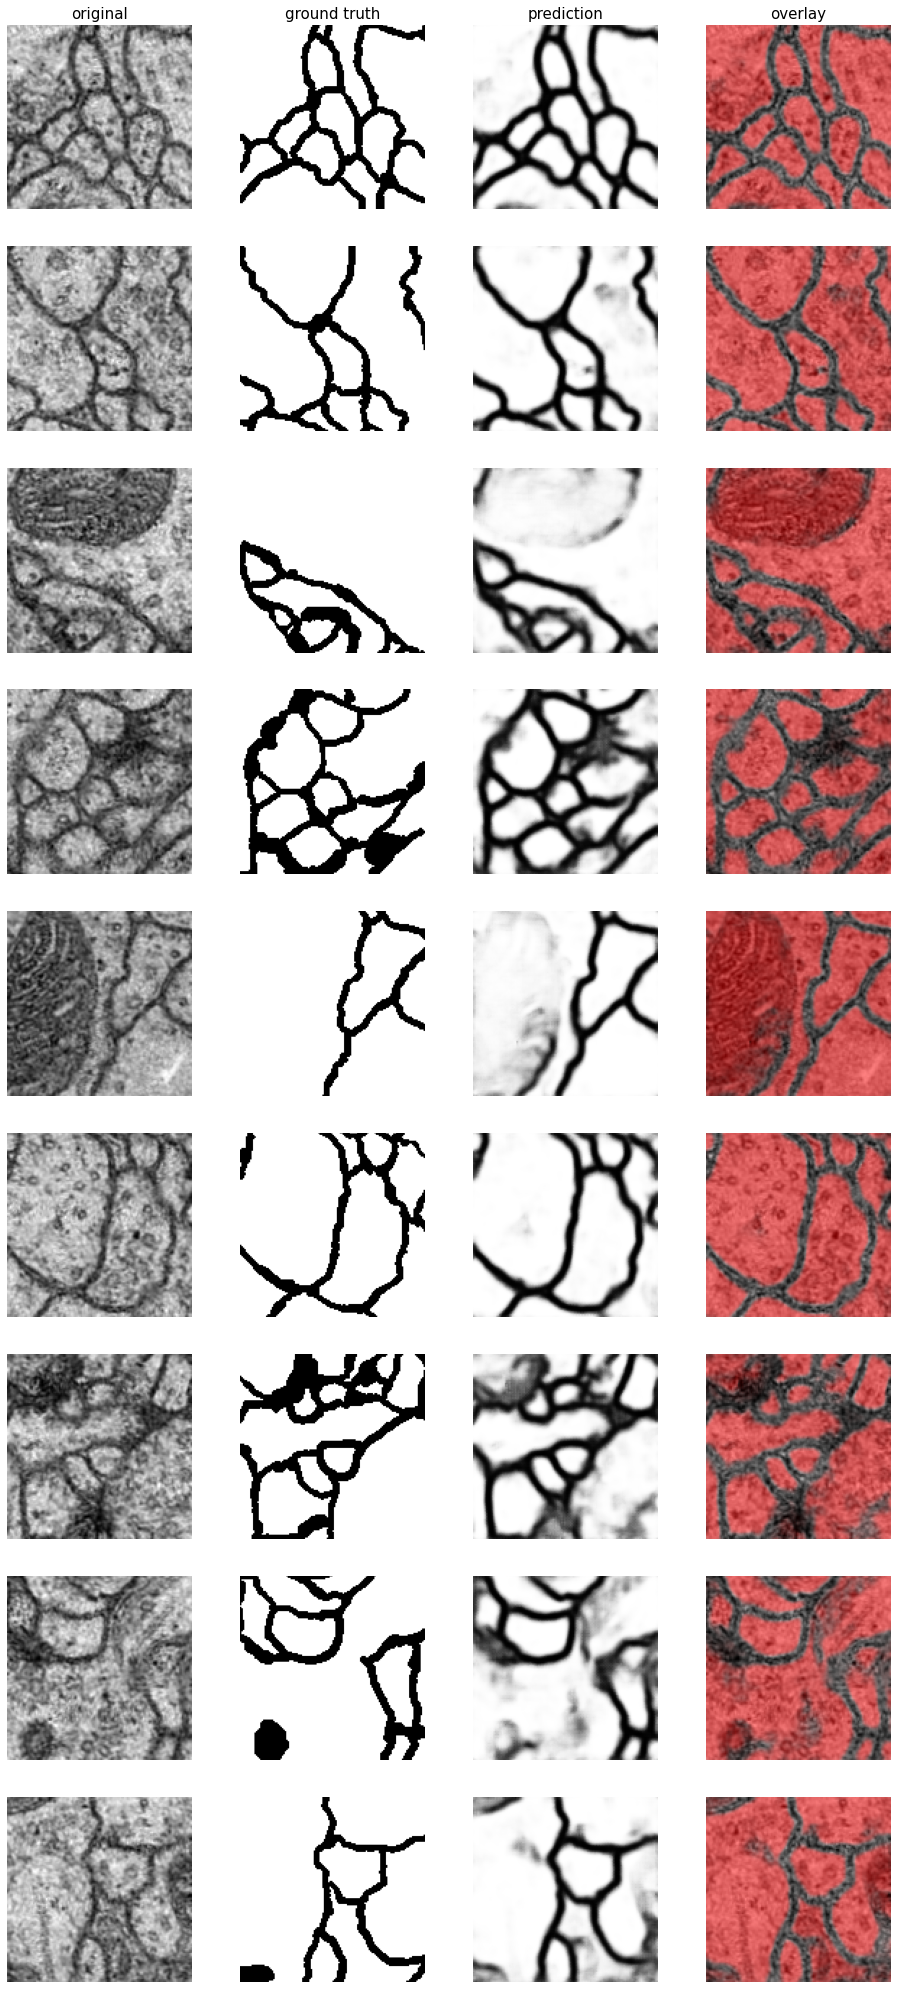

In [26]:
plot_imgs(org_imgs=x_test_tiles, mask_imgs=y_test_tiles, pred_imgs=y_test_pred_binx_tiles, nm_img_to_plot=9)

Abusing the labelling a bit ...

-Ground truth is actually Jaccard trained prediction

-Prediction is the binary cross entropy trained prediction


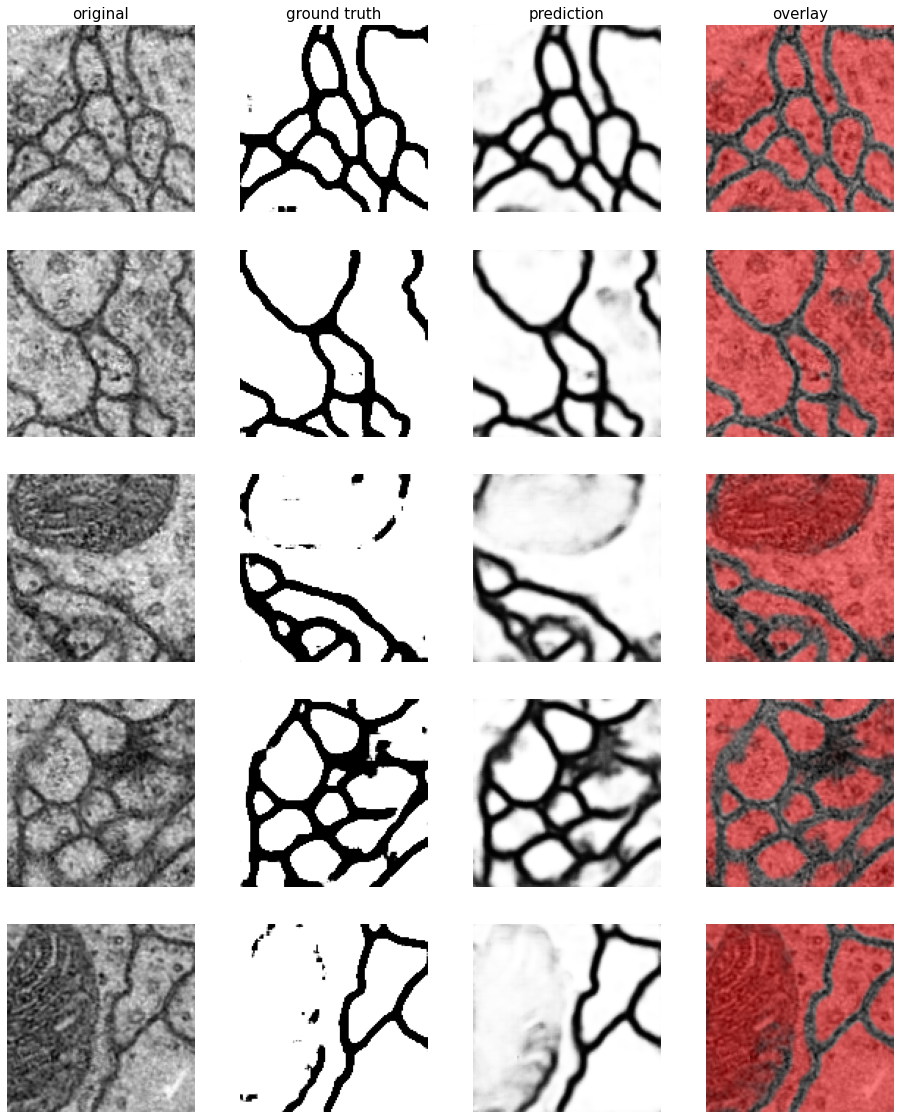

In [27]:
plot_imgs(org_imgs=x_test_tiles, mask_imgs=y_test_pred_tiles, pred_imgs=y_test_pred_binx_tiles, nm_img_to_plot=5)